### Données d'application 

Nous allons utiliser des données qui sont disponible sur le site que [Bruce Hansen](https://www.ssc.wisc.edu/~bhansen/) dédie à son cours d'[économétrie](https://www.ssc.wisc.edu/~bhansen/econometrics/). Plus précisément, nous allons utiliser des données extraites du **Current Population Survey**(CPS) de 2009. Une description du fichier est [ici](https://www.ssc.wisc.edu/~bhansen/econometrics/cps09mar_description.pdf)



In [13]:
# Imports

import pandas as pd   
import numpy as np
import statsmodels.api as sm
from sklearn import linear_model
import matplotlib.pyplot as plt

In [2]:
# Lecture des données.
# On utilise la fonction "read_stata" dans pandas pour lire le fichier au format stata(".dta") disponible 
# sur le site de Bruce Hansen. Vous pouvez aussi le télécharger sur votre poste et ensuite le lire.
# Nous l'appellons cps_df(pour cps data frame)

cps_df = pd.read_stata("https://www.ssc.wisc.edu/~bhansen/econometrics/cps09mar.dta")
cps_df.info()   # Affichage d'informations.


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50742 entries, 0 to 50741
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        50742 non-null  float64
 1   female     50742 non-null  float64
 2   hisp       50742 non-null  float64
 3   education  50742 non-null  float64
 4   earnings   50742 non-null  float64
 5   hours      50742 non-null  float64
 6   week       50742 non-null  float64
 7   union      50742 non-null  float64
 8   uncov      50742 non-null  float64
 9   region     50742 non-null  float64
 10  race       50742 non-null  float64
 11  marital    50742 non-null  float64
dtypes: float64(12)
memory usage: 4.6 MB


In [3]:
# Affichage des premières lignes(5 par défaut) et de statistiques descriptives de base(moyennes, écart-types, etc)
print(cps_df.head())
cps_df.describe()

    age  female  hisp  education  earnings  hours  week  union  uncov  region  \
0  52.0     0.0   0.0       12.0  146000.0   45.0  52.0    0.0    0.0     1.0   
1  38.0     0.0   0.0       18.0   50000.0   45.0  52.0    0.0    0.0     1.0   
2  38.0     0.0   0.0       14.0   32000.0   40.0  51.0    0.0    0.0     1.0   
3  41.0     1.0   0.0       13.0   47000.0   40.0  52.0    0.0    0.0     1.0   
4  42.0     0.0   0.0       13.0  161525.0   50.0  52.0    1.0    0.0     1.0   

   race  marital  
0   1.0      1.0  
1   1.0      1.0  
2   1.0      1.0  
3   1.0      1.0  
4   1.0      1.0  


,age,female,hisp,education,earnings,hours,week,union,uncov,region,race,marital
count,50742.000000,50742.000000,50742.000000,50742.000000,50742.000000,50742.000000,50742.000000,50742.000000,50742.000000,50742.000000,50742.000000,50742.000000
mean,42.131725,0.425722,0.148792,13.924619,55091.530685,43.827244,51.879272,0.021521,0.002207,2.635627,1.433507,2.763174
std,11.487620,0.494457,0.355887,2.744447,52222.071166,7.704467,0.598646,0.145113,0.046930,1.060051,1.317430,2.503158
min,15.000000,0.000000,0.000000,0.000000,1.000000,36.000000,48.000000,0.000000,0.000000,1.000000,1.000000,1.000000
25%,33.000000,0.000000,0.000000,12.000000,28000.000000,40.000000,52.000000,0.000000,0.000000,2.000000,1.000000,1.000000
50%,42.000000,0.000000,0.000000,13.000000,42000.000000,40.000000,52.000000,0.000000,0.000000,3.000000,1.000000,1.000000
75%,51.000000,1.000000,0.000000,16.000000,65000.000000,45.000000,52.000000,0.000000,0.000000,4.000000,1.000000,5.000000
max,85.000000,1.000000,1.000000,20.000000,561087.000000,99.000000,52.000000,1.000000,1.000000,4.000000,21.000000,7.000000


#### Calcul de l'estimateur des MCO

Le modèle que nous allons estimer suppose que,

$$
\begin{align*}
Y &= X^\top \beta + U, \tag{1}
\end{align*}
$$

où $ Y\in \mathbb{R} $, $ X\in\mathbb{R}^K $, $ U\in \mathbb{R} $, sont de variables aléatoires: $ Y $ est la variables dépendante, 
$ X $ sont $ K $ régresseurs, $ U $ est l'erreur du modèle. $ Y $ et $ X $ sont observables tandis que $ U $ représente tout ce qui peut faire 
varier $ Y $ pour des valeurs données de $ X $. $ \beta \in \mathbb{R}^K $ sont les paramètres inconnus du modèle qu'on se propose d'estimer car
ils permettent de mesurer la relation entre les éléments de $ X $ et $ Y $ sans pour autant que cette relation si elle existe puisse avoir une 
interprétation causale ou en termers de modèle de régression. 

En effet ici on se contente de calculer l'estimateur des MCO défini sur des données sur (Y, X) $, $ \{(Y_i, X_i)\}_{i=1}^n $,

$$
\begin{align*}
\hat{\beta}_n^{MCO} &=  \arg\min_{b\in \mathbb{R}^K} n^{-1}\sum_{i=1}^n(Y_i - X_i^\top b)^2 \tag{2}
\end{align*}
$$

On peut alors calculer $ \hat{\beta}_n^{MCO} $ dès lors que $ n^{-1}\sum_{i=1}^n X_iX_i^\top $ est de plein rang ce qui revient à l'absence d
multicolinéarité entre régrésseurs dans l'échantillon. On obtient alors,

$$
\begin{align*}
\hat{\beta}_n^{MCO} &= \left( n^{-1}\sum_{i=1}^n X_iX_i^\top \right)^{-1} n^{-1}\sum_{i=1}^n X_iY_i = \left(\mathbf{X}^\top \mathbf{X}\right)^ {-1} \mathbf{X}^\top\mathbf{Y}  \tag{3}
\end{align*}
$$

où:
- $ \mathbf{X} $  est la matrice $ n\times K$ des régrésseurs avec la $i$-ème ligne égale à $ X_i^\top $,
- $ \mathbf{Y} $  est le vecteur $ n\times 1$ de toutes les observations de la variable dépendante de $i$-ème élément égal à $ Y_i^\top $.

On peut se contenter d'une interprétation non causale ni en termes de modèle de régression en supposant $ \operatorname{E}(XU) =0$, auquel cas 
on estime les coefficients de la projection de $Y$ sur $X$ définie par,

$$
\begin{align*}
\beta &=  \arg\min_{b\in \mathbb{R}^K}\operatorname{E}\left((Y_i - X_i^\top b)^2\right) \tag{3}
\end{align*}
$$

#### Calcul matriciel pour l'estimateur des MCO avec numpy

Pour pouvoir utiliser des fonction de numpy pour du calcul matriciel nous avons besoin de définir des objets de type array sur lesquels travaille numpy. Ces objets incluant matrices et vecteurs. 


#### Application.

- Nous allons considérer un modèle où la variable dépendante est un log du salaire, et les régresseurs incluent une constante, le niveau d'études, une mesure de l'expérience potentielle sur le marché du travail en années($ \text{exper} $), son carré($ \text{expersq} $), et une indicatrice du sexe($ \text{female} $). Soit,

  - $ Y $: $ \text{lwage} $(salaire horaire en log),
  - $ X $: $ (1, \text{education}, \text{exper}, \text{expersq}, \text{female})$.

- Parmi ces variables nous devons construire $ \text{lwage} $, $\text{exper}$, $\text{expersq}$.

- Donc la version de (1) qu'on considère est:

$$ 
\begin{align*}
\text{lwage} &= \beta_1 + \beta_2 \text{education} + \beta_3\text{exper} + \beta_4\text{exper}^2  + \beta_5\text{female} 
+ U
\end{align*}
$$

- Nous allons utiliser un échantillon qui correspond aux personnes qui se définissent comme blanches, ou noires(remarque: la collecte de données américaines permet de recueillir des informations quant à l'appartenance à des groupes ethniques préalablement définis).


In [4]:
# Échantillon

cps_df2 = cps_df[(cps_df.race == 1.0) | (cps_df.race == 2.0)]

# Variables

cps_df2 = cps_df2.assign(exper = cps_df2.age - cps_df2.education - 6) # Expérience
cps_df2 = cps_df2.assign(expersq = cps_df2.exper**2/100) # Expérience au carré
cps_df2 = cps_df2.assign(lwage = np.log(cps_df2.earnings / ( cps_df2.hours * cps_df2.week))) # revenu horaire
#cps_df2 = pd.get_dummies(data = cps_df2, columns= ['race']) # indicatrice d'appartenance ethnique
#cps_df2 = cps_df2.rename(columns={"race_1.0": "white", "race_2.0": "black"}) # on les renomme 
print(cps_df2.shape)
cps_df2.describe()
#cps_df2[['exper', 'age', 'education', 'expersq', 'lwage', 'earnings', 'week', 'hours']].head()


(46411, 15)


,age,female,hisp,education,earnings,hours,week,union,uncov,region,race,marital,exper,expersq,lwage
count,46411.000000,46411.000000,46411.000000,46411.000000,46411.000000,46411.000000,46411.000000,46411.000000,46411.000000,46411.000000,46411.000000,46411.000000,46411.000000,46411.000000,46411.000000
mean,42.213915,0.423477,0.154468,13.882269,55082.729181,43.879964,51.879554,0.021934,0.002262,2.597789,1.110642,2.754584,22.331646,6.337939,2.945706
std,11.468616,0.494115,0.361400,2.713667,52324.915589,7.701222,0.596815,0.146471,0.047511,1.047513,0.313692,2.497897,11.623014,5.635276,0.673137
min,15.000000,0.000000,0.000000,0.000000,1.000000,36.000000,48.000000,0.000000,0.000000,1.000000,1.000000,1.000000,-4.000000,0.000000,-7.863267
25%,33.000000,0.000000,0.000000,12.000000,28000.000000,40.000000,52.000000,0.000000,0.000000,2.000000,1.000000,1.000000,13.000000,1.690000,2.560096
50%,42.000000,0.000000,0.000000,13.000000,42000.000000,40.000000,52.000000,0.000000,0.000000,3.000000,1.000000,1.000000,22.000000,4.840000,2.956512
75%,51.000000,1.000000,0.000000,16.000000,65000.000000,45.000000,52.000000,0.000000,0.000000,3.000000,1.000000,5.000000,31.000000,9.610000,3.354542
max,85.000000,1.000000,1.000000,20.000000,561087.000000,99.000000,52.000000,1.000000,1.000000,4.000000,2.000000,7.000000,75.000000,56.250000,5.583706


In [5]:
# Variables(dépendante et régresseurs)

dep_var = cps_df2['lwage']
reg_var = cps_df2[['education', 'female',  'exper', 'expersq']]

# Ce ne sont pas array mais des objets pour pandas leur type est

print(type(dep_var), type(reg_var))

# Conversion en arrays pour numpy(on crée de nouveaux objets Yn, Xn, afin de ne pas écraser ceux de départ
# que nous utiliserons par la suite.

Y = dep_var.values[:, np.newaxis]
X = reg_var.values
n = len(Y)
# On estime un modèle avec terme constant qu'on doit joindre
X = np.concatenate((np.ones((n,1)), X), axis=1) 
print(type(Y), Y.shape)
print(type(X), X.shape)

# Calcul de l'estimateur

beta_hat=np.linalg.inv(X.T@X) @ (X.T@Y) # "@" pour le produit matriciel ".T" pour la transposé, et "np.linalg.inv" pour l'inverse
print(beta_hat)

<class 'pandas.core.series.Series'> <class 'pandas.core.frame.DataFrame'>
<class 'numpy.ndarray'> (46411, 1)
<class 'numpy.ndarray'> (46411, 5)
[[ 1.00445476]
 [ 0.11533072]
 [-0.26840208]
 [ 0.03688896]
 [-0.05836749]]


#### Calcul avec modules existants

En général pour une tâche donnée, il est recommandé d'utiliser des modules/bibliothèques/fonctions déjà existantes plutôt que de chercher à les reprogrammer de zéro(bien que cet exercice soit très instructif) car ces fonctions on souvent été déjà largement testées, et surtout cela permet 
d'envisage des développements/améliorations sur des bases établies.

Par exemple, pour calculer un estimateur des MCO il existe énormément de modules disponible largement employés par la communauté. Nous allons en considérer deux associés à deux bibliothèques parmi les plus populaires:

- [statsmodels](https://www.statsmodels.org/stable/index.html): orienté statistique au sens général.

- [scikit-learn](https://scikit-learn.org/stable/): davantage apprentissage.

**statsmodels**

Une syntaxe de base est la suivante:

In [6]:
model = sm.OLS(dep_var, sm.add_constant(reg_var))
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  lwage   R-squared:                       0.277
Model:                            OLS   Adj. R-squared:                  0.277
Method:                 Least Squares   F-statistic:                     4445.
Date:                Mon, 02 Dec 2024   Prob (F-statistic):               0.00
Time:                        14:19:52   Log-Likelihood:                -39958.
No. Observations:               46411   AIC:                         7.993e+04
Df Residuals:                   46406   BIC:                         7.997e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0045      0.017     59.585      0.0

Plusieurs options sont disponibles, et par exemple pour avoir des écart-types estimés robustes à l'hétéroscédasticité:

In [7]:
results2 = model.fit(cov_type='HC0')
print(results2.summary())

                            OLS Regression Results                            
Dep. Variable:                  lwage   R-squared:                       0.277
Model:                            OLS   Adj. R-squared:                  0.277
Method:                 Least Squares   F-statistic:                     3544.
Date:                Mon, 02 Dec 2024   Prob (F-statistic):               0.00
Time:                        14:20:26   Log-Likelihood:                -39958.
No. Observations:               46411   AIC:                         7.993e+04
Df Residuals:                   46406   BIC:                         7.997e+04
Df Model:                           4                                         
Covariance Type:                  HC0                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0045      0.019     54.204      0.0

**Remarques**

- Comme pour le type d'écart-types plusieurs options sous forme d'arguments de la fonction existent. Pour plus de détails vous pouvez 
consulter la [documentation](https://www.statsmodels.org/dev/regression.html) et ou faire des rechercher(sur le web) en fonction de vos besoins.

- L'option HC0 est une parmi d'autres disponibles pour les écart-types robustes à l'hétéroscédasticité, les autres étant 'HC1', 'HC2', 'HC3'. Pour de détails vous pouvez regarder la section 4.13 du [cours en pdf](https://www.ssc.wisc.edu/~bhansen/econometrics/Econometrics.pdf) de Bruce Hansen.

#### Sklearn

Comme indiquée plus haut c'est une bibliothèque très populaire dans la communauté de l'apprentissage et donc pour ce qui concerne les questions de régression surtout concentré sur les problèmes de prédiction et non d'inférence comme ils est traditionnel en économétrie et statistique, et dans les questions économiques où l'on s'intéresse beaucoup à la mesure de relations causales. Néanmoins une litterature très abondante en économétrie théorique adapte et développe des outils initialement développés en apprentissage pour l'économie appliquée.

In [8]:
sklr_model = linear_model.LinearRegression()

# fit the model
sklr_model.fit(reg_var, dep_var)

print(sklr_model.intercept_, sklr_model.coef_)

1.0044547623709081 [ 0.11533072 -0.26840208  0.03688896 -0.05836749]


In [9]:
colors = ['#165aa7', '#cb495c', '#fec630', '#bb60d5', '#f47915', '#06ab54', '#002070', '#b27d12', '#007030']

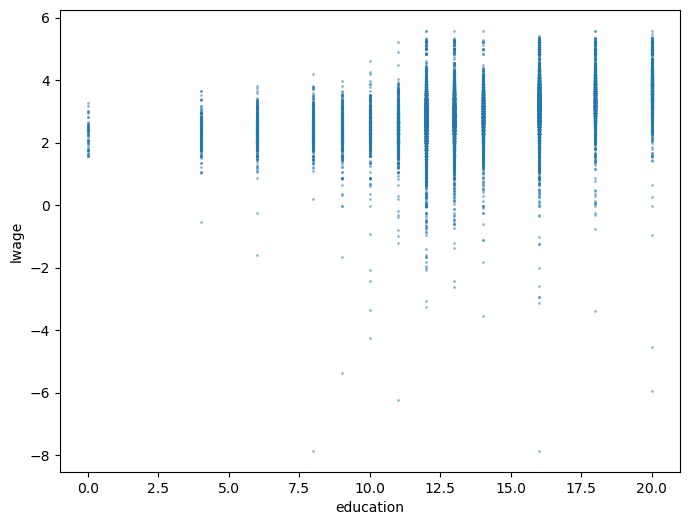

In [14]:
def var_scatter(df, ax=None, var="education"):
    if ax is None:
        _, ax = plt.subplots(figsize=(8, 6))
    df.plot.scatter(x=var , y="lwage", alpha=0.35, s=1.5, ax=ax)

    return ax

var_scatter(cps_df2);

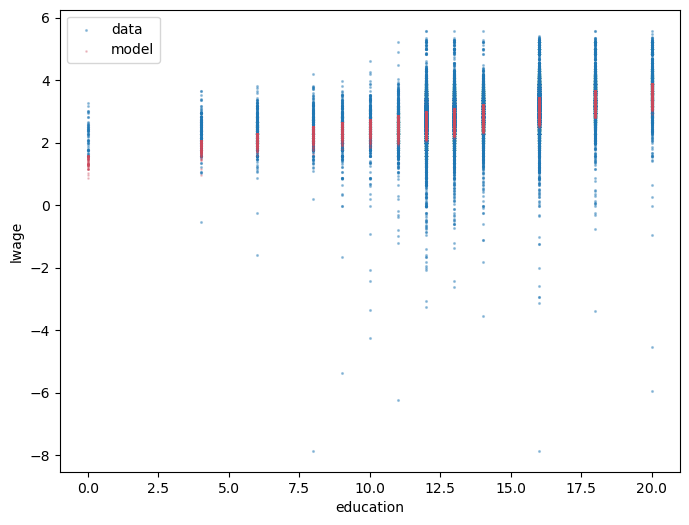

In [15]:
import seaborn as sns
ax = var_scatter(cps_df2)
def scatter_model(mod, X, ax=None, color=colors[1], x="education"):
    if ax is None:
        _, ax = plt.subplots()

    ax.scatter(X[x], mod.predict(X), c=color, alpha=0.25, s=1)
    return ax

scatter_model(sklr_model, reg_var, ax, color=colors[1])
ax.legend(["data", "model"])